<a href="https://colab.research.google.com/github/injoon-pij/dlnlp-learning/blob/main/dlnlp_word_embedding(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Word2Vec

https://github.com/injoon-pij/pytorch-learning/blob/master/pytorch_word_embedding.ipynb

위 링크의 __2) Word2Vec__ 참고

## 1.1 NNLM vs. Word2Vec

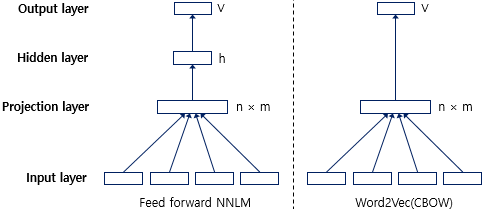

* Feed Forward NNLM
 * 언어 모델이므로 다음 단어를 예측
 * 예측 단어의 이전 단어들만을 참고
 * 투사층과 출력층 사이에 활성화 함수가 있는 은닉층이 존재하는 구조
 * 연산량 : $(n × m) + (n × m × h) + (h × V)$

* Word2Vec(CBOW)
 * 워드 임베딩 자체가 목적이므로 다음 단어가 아닌 중심 단어를 예측
 * 예측 단어의 전후 단어들을 모두 참고
 * 투사층 다음에 바로 출력층으로 연결되는 구조
 * 연산량 : $(n × m) + (m × log(V))$
    * 피드포워드 NNLM 보다 훨씬 빠름

# 2) Training Word2Vec model

## 2.1 Engilsh model

https://github.com/injoon-pij/pytorch-learning/blob/master/pytorch_word_embedding.ipynb

위 링크의 __3.1 English model__ 참고

## 2.2 Korean model(NSMC)

### 2.2.1 Data Load & preprocessing

In [ ]:
!pip install konlpy

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [8]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f3c9e73d090>)

In [9]:
train_data = pd.read_table('ratings.txt')
print(len(train_data)) # 리뷰 개수 출력
train_data[:5]

200000


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [10]:
# NULL 값 유무 확인
print(train_data.isnull().values.any()) # True

train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

# Null 값 유무 재확인
print(train_data.isnull().values.any())

print(len(train_data)) # 리뷰 개수 출력

True
False
199992


[데이터 정제]
* 한글 외 문자 제거
* 형태소 토큰화
* 불용어 제거

In [11]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# 형태소 분석기 Okt
okt = Okt()

In [12]:
# 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 형태소 분석기 Okt로 토큰화
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


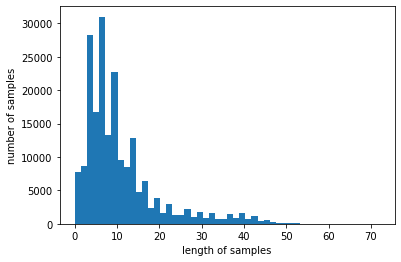

In [13]:
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
tokenized_data[0]

['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ']

### 2.2.2 Train Word2Vec model

In [15]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [16]:
model.wv.vectors.shape

(16477, 100)

In [17]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8789173364639282), ('안성기', 0.8632208704948425), ('크리스찬', 0.8424921631813049), ('이정재', 0.8404560089111328), ('김명민', 0.8368001580238342), ('브란도', 0.8302786946296692), ('베일', 0.8296118974685669), ('황정민', 0.825263261795044), ('송강호', 0.8240981101989746), ('김희선', 0.8226162195205688)]


In [18]:
print(model.wv.most_similar("히어로"))

[('호러', 0.8678215742111206), ('무협', 0.8654085397720337), ('슬래셔', 0.8486829996109009), ('느와르', 0.8484187722206116), ('물', 0.8401306867599487), ('정통', 0.837444543838501), ('멜로', 0.8200139999389648), ('물의', 0.8178898692131042), ('무비', 0.8128746747970581), ('블랙', 0.8032995462417603)]


## 2.3 Korean model(Wikipedia)

https://github.com/injoon-pij/pytorch-learning/blob/master/pytorch_word_embedding.ipynb

위 링크의 __3.2 Korean model__ 참고

# 3) Embedding Visualization

https://github.com/injoon-pij/pytorch-learning/blob/master/pytorch_word_embedding.ipynb

위 링크의 __4) Embedding Visualization__ 참고

# 4) Negative Sampling

* Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법
 * 가령, 현재 집중하고 있는 주변 단어가 '고양이', '귀여운'일 때, 단어 집합에서 무작위로 선택한 __주변 단어가 아닌 단어들을__ 일부 가져와 하나의 중심 단어에 대해서 전체 단어 집합보다 훨씬 작은 단어 집합을 만들어놓고 마지막 단계를 이진 분류 문제로 변환함
 * 주변 단어들을 긍정(positive), 랜덤으로 샘플링 된 단어들을 부정(negative)으로 레이블링하여 이진 분류 문제를 위한 데이터셋을 구성함
 * 기존의 단어 집합의 크기만큼의 선택지를 두고 다중 클래스 분류 문제를 풀던 Word2Vec보다 훨씬 연산량에서 효율적임

## 4.1 Skip-Gram with Negative Sampling, SGNS

__[기존 Skip-Gram]__
* 중심단어로부터 주변 단어 예측

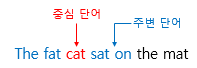

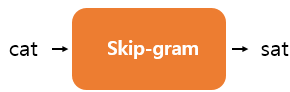

__[네거티브 샘플링을 사용하는 Skip-gram]__
* 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 그 확률을 예측

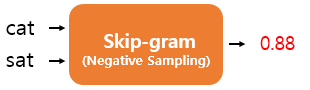

__[기존의 Skip-gram 데이터셋을 SGNS의 데이터셋으로 바꾸는 과정]__

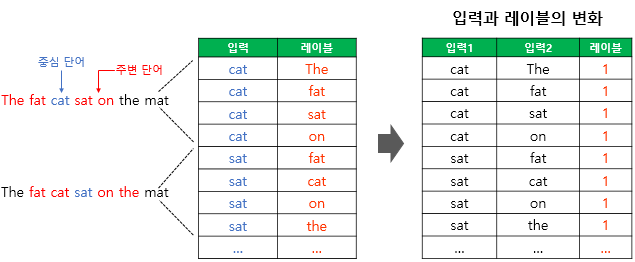

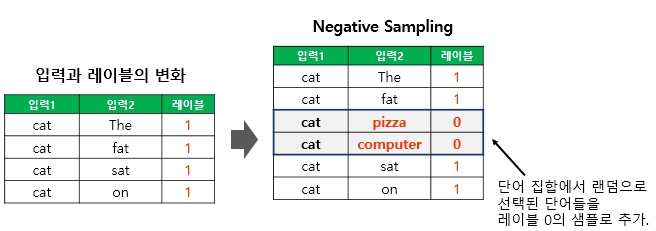

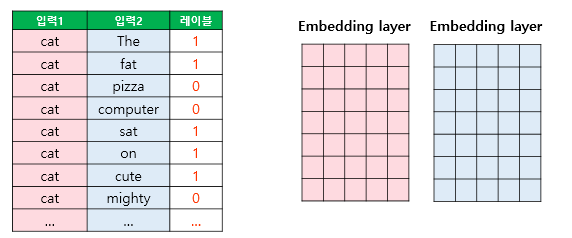

두 테이블 중 하나는 입력 1인 중심 단어의 테이블 룩업을 위한 임베딩 테이블, 하나는 입력 2인 주변 단어의 테이블 룩업을 위한 임베딩 테이블
 * 두 임베딩 테이블은 훈련 데이터의 단어 집합의 크기를 가지므로 크기가 같음

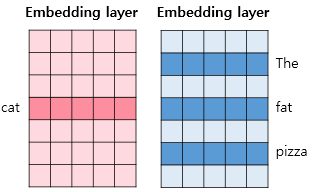

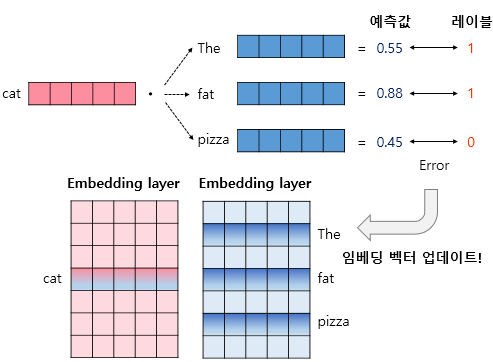

* 중심 단어와 주변 단어의 내적값을 이 모델의 예측값으로 하고, 레이블과의 오차로부터 역전파하여 중심 단어와 주변 단어의 임베딩 벡터값을 업데이트
* 이후에는 선택적으로 두 개의 임베딩 테이블 중 좌측의 테이블을 최종 임베딩 테이블로 사용

## 4.2 Modeling

### 4.2.1 Data preprocessing

In [28]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [34]:
news_df = pd.DataFrame({'document':documents})

# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 짧은 단어 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [35]:
# 데이터프레임에 Null 값이 있는지 확인
print(news_df.isnull().values.any()) # False

# 데이터프레임에 NaN 값(빈 값)이 있는지 확인 위해 빈값을 Null 값으로 변환
news_df.replace("", float("NaN"), inplace=True)
print(news_df.isnull().values.any()) # True

# Null 값을 제거
news_df.dropna(inplace=True)

print('총 샘플 수 :',len(news_df))

False
True
총 샘플 수 : 10995


In [36]:
# 불용어 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [37]:
# 단어가 1개 이하인 문장 샘플 제거
tokenized_doc = [sentence for index, sentence in enumerate(tokenized_doc) if len(sentence) > 1]

print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [32]:
# tokenizer가 생성한 단어 집합은 인덱스가 1부터 시작하므로
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


### 4.2.2 Dataset for Negative Sampling 

In [39]:
from tensorflow.keras.preprocessing.sequence import skipgrams

In [40]:
# 네거티브 샘플링 (상위 10개 샘플)
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록 하고, 그렇지 않은 경우는 0의 레이블을 가지도록 하여 데이터셋을 구성

In [42]:
# 첫번째 뉴스 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
sample_1 = skip_grams[0]
pairs, labels = sample_1[0], sample_1[1]

for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(subsidizing (15228), whole (217)) -> 1
(incidences (20294), israels (13686)) -> 1
(away (178), guilt (4989)) -> 1
(media (702), israeli (442)) -> 1
(report (581), europeans (4520)) -> 1


In [50]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [51]:
# 네거티브 샘플링 (전체 샘플)
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

### 4.2.3 Modeling SGNS by Keras

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [53]:
# 임베딩 벡터 차원
embed_size = 100

In [54]:
# 다중입력모델 (Functional API 사용)

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

# 임베딩 테이블을 통해 얻은 두 단어벡터 내적
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

* 각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블
* 각 단어는 임베딩 테이블을 거친 뒤 내적을 수행
* 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 계산

In [55]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_2[0][0]                    
______________________________________________________________________________________________

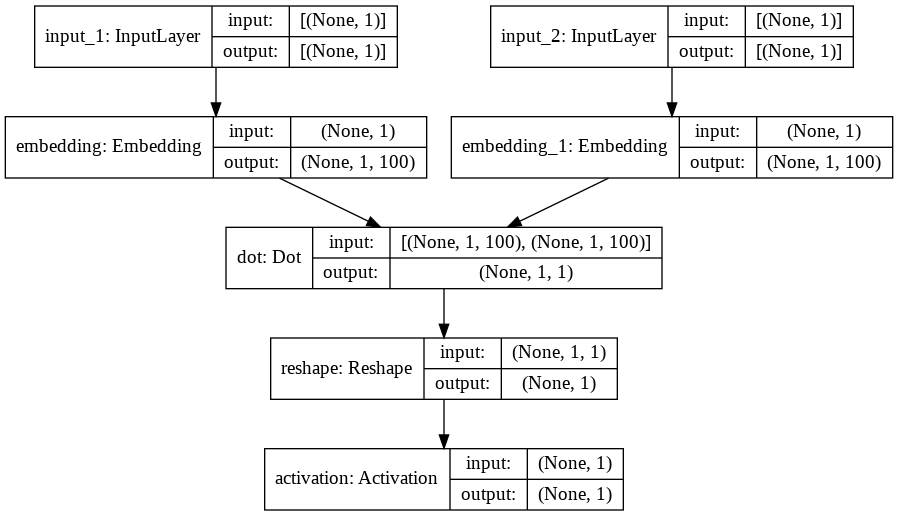

In [56]:
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [57]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4629.55679878965
Epoch : 2 Loss : 3683.304484920576
Epoch : 3 Loss : 3534.595868850127
Epoch : 4 Loss : 3327.5409430637956
Epoch : 5 Loss : 3100.774100350216


* ```zip(*arg)```
 * 함수의 인수에 *를 붙여서 입력하면 2차원 리스트에서 row가 아닌 col끼리 서로 엮어줌 (axis = 1)
* ```model.train_on_batch```
 * 하나의 데이터 배치에 대해서 경사 업데이트를 1회 실시합니다.

### 4.2.4 Result

In [58]:
import gensim

In [59]:
# 임베딩 벡터 테이블 저장
f = open('vectors.txt' ,'w')

f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))

f.close()

In [60]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [61]:
w2v.most_similar(positive=['soldiers'])

[('bemoaning', 0.7770929336547852),
 ('shelling', 0.7749819755554199),
 ('withdrew', 0.7732988595962524),
 ('villages', 0.7697315812110901),
 ('towns', 0.7683924436569214),
 ('retaliation', 0.7675638198852539),
 ('massacred', 0.7609399557113647),
 ('disarmed', 0.7508403062820435),
 ('wounded', 0.7503498196601868),
 ('fleeing', 0.7500933408737183)]

In [62]:
w2v.most_similar(positive=['doctor'])

[('stopping', 0.5949554443359375),
 ('patient', 0.56290602684021),
 ('allergic', 0.5521577596664429),
 ('headaches', 0.5512917637825012),
 ('heart', 0.5493628978729248),
 ('liking', 0.5368105173110962),
 ('pain', 0.52799391746521),
 ('quack', 0.5137800574302673),
 ('meal', 0.5044955015182495),
 ('bruise', 0.49811968207359314)]

In [63]:
w2v.most_similar(positive=['police'])

[('officers', 0.6116905808448792),
 ('houses', 0.5614897012710571),
 ('accused', 0.5601733326911926),
 ('armed', 0.5528470277786255),
 ('suspend', 0.5510799288749695),
 ('ammunition', 0.5506342649459839),
 ('concealed', 0.5420693755149841),
 ('defend', 0.5318718552589417),
 ('prisoners', 0.5305759906768799),
 ('weapons', 0.5279604196548462)]

In [64]:
w2v.most_similar(positive=['knife'])

[('saddam', 0.7506735324859619),
 ('involvement', 0.744055986404419),
 ('began', 0.7370647192001343),
 ('deeds', 0.7239992618560791),
 ('innocent', 0.7218998670578003),
 ('miniscule', 0.718147873878479),
 ('minority', 0.6984174847602844),
 ('liar', 0.6969383955001831),
 ('peaceful', 0.690329372882843),
 ('slaughtering', 0.6902257800102234)]

In [65]:
w2v.most_similar(positive=['engine'])

[('brake', 0.6130862236022949),
 ('valve', 0.5836495161056519),
 ('rebuilt', 0.5791158676147461),
 ('speeds', 0.5678214430809021),
 ('clutch', 0.5651389360427856),
 ('horn', 0.5632684230804443),
 ('brakes', 0.5436698198318481),
 ('trunk', 0.5344934463500977),
 ('front', 0.5215569734573364),
 ('rear', 0.5177029371261597)]

# 5) GloVe

https://github.com/injoon-pij/pytorch-learning/blob/master/pytorch_word_embedding.ipynb

위 링크의 __5) GloVe__ 참고

# 6) FastText

페이스북에서 개발한 단어를 벡터로 만드는 방법

* Word2Vec는 단어를 쪼개질 수 없는 단위로 생각한다면, FastText는 하나의 단어 안에도 여러 단어들이 존재하는 것으로 간주함(내부 단어(subword)를 고려) 즉, 각 단어를 __글자 단위 n-gram의 구성으로 취급__
 * (ex) apple
   * (n=3) <ap, app, ppl, ple, le> , \<apple>
   * n-gram 외에도 기존 단어에 <, 와 >를 붙인 특별토큰도 벡터화함
 * 실제 사용할 때는 n의 최소값과 최대값으로 범위를 설정할 수 있음(기본값 : 3, 6)
   * (n=3~6) <ap, app, ppl, ppl, le>, <app, appl, pple, ple>, <appl, pple>, ..., \<apple>
 * 내부 단어들(n-gram)에 대해서 Word2Vec을 수행하고, 그 벡터값들을 총 합친 것이 기존 단어의 벡터값이 됨
   * apple = <ap + app + ppl + ppl + le> + <app + appl + pple + ple> + <appl + pple> + , ..., + \<apple>

* 내부 단어를 통해 모르는 단어(Out Of Vocabulary, OOV)에 대해서도 다른 단어와의 유사도를 계산할 수 있음
 * FastText에서 birthplace란 단어를 학습하지 않았어도 다른 단어에서 birth와 place라는 내부 단어가 있었다면, FastText는 birthplace의 벡터를 얻을 수 있음
 * OOV에 제대로 대처할 수 없는 Word2Vec, GloVe와 다른 점

* 단어의 등장 빈도 수가 적은 희귀 단어라도, 그 단어의 n-gram이 다른 단어의 n-gram과 겹치는 경우라면, 비교적 높은 정확도의 임베딩 벡터값을 가짐
 * 이러한 원리로 노이즈가 많은 코퍼스에서 강점을 가짐
 * 많은 실제 비정형 데이터에는 오타가 섞여있는데, 등장 빈도가 적어 희귀 단어에 속하는 오타 섞인 단어를 Word2Vec에 비해 비교적 정확하게 임베딩함
   * Word2Vec의 경우 등장 빈도 수가 적은 단어에 대해서는 참고할 수 있는 경우의 수가 적다보니 임베딩의 정확도가 높지 않다는 단점이 있음
 * 예를 들어 단어 apple과 오타로 p를 한 번 더 입력한 appple의 경우에는 많은 개수의 동일한 n-gram을 가질 것이므로 임베딩된 벡터값이 비슷할 것임

## 6.1 Word2Vec vs. FastText

2.1 에서 사용한 Word2Vec 모델 사용

"electrofishing" : OOV

In [20]:
model.wv.most_similar("electrofishing")

KeyError: ignored

In [21]:
from gensim.models import FastText
model = FastText(result, size=100, window=5, min_count=5, workers=4, sg=1)

In [22]:
model.wv.most_similar("electrofishing")

[('electrolux', 0.8201629519462585),
 ('electrolyte', 0.8098382353782654),
 ('electro', 0.8047101497650146),
 ('electric', 0.7940026521682739),
 ('electrochemical', 0.7829729318618774),
 ('electrogram', 0.774043619632721),
 ('electroshock', 0.7740335464477539),
 ('electroencephalogram', 0.7669188380241394),
 ('airbus', 0.7570081353187561),
 ('electron', 0.7567839622497559)]

Word2Vec는 학습하지 않은 단어에 대해서 유사한 단어를 찾아내지 못 했지만, FastText는 유사한 단어를 계산해서 출력함

## 6.2 FastText in Korean

1. 음절단위 임베딩
 * ex) 자연어처리 -> <자연, 자연어, 연어처, 어처리, 처리> (n=3)

2. 자모 단위 임베딩
 * 오타나 노이즈 측면에서 더 강한 임베딩을 기대해볼 수 있음
 * ex) 자연어처리 -> < ㅈ ㅏ, ㅈ ㅏ _, ㅏ _ ㅇ, ... (n=3)